## **1. Importing Package and Required Modules**

### 1.1 Installation of the necessary modules.

In [ ]:
%pip install seaborn
%pip install scikit-learn
%pip install matplotlib
%pip install networkx
%pip install aisp

### 1.2 Importing the Required Libraries

In [1]:
# Importing the Artificial Immune Network (AiNet)
from aisp.ina import AiNet

# Libraries for data manipulation and numerical computations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx

# Functions for calculating minimum spanning trees and distances
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import squareform, pdist

## 2 Visualization Function:

In [2]:
def plot_immune_network(train_x, train_y, predict_y, model, title_prefix=""):
    clusters = list(model._memory_network.values())
    network = np.array(model._population_antibodies)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    colors = colormaps.get_cmap('Accent')

    color_map = {'long': 'green', 'short': 'red'}

    # Creating a color list based on categorical train_y
    colors_train = [color_map[label] for label in train_y]

    # Original data
    axs[0][0].scatter(train_x[:, 0], train_x[:, 1], color=colors_train, alpha=0.9, s=50, marker='o', edgecolors='k')
    axs[0][0].set_title(f'{title_prefix}Original data', fontsize=16)
    axs[0][0].set_xlabel('X', fontsize=14)
    axs[0][0].set_ylabel('Y', fontsize=14)
    axs[0][0].grid(True, linestyle='--', alpha=0.5)

    # Antibody population
    axs[0][1].scatter(network[:, 0], network[:, 1], color='crimson', alpha=0.9, s=70, marker='.', edgecolors='k')
    axs[0][1].set_title(f'{title_prefix}Antibody population', fontsize=16)
    axs[0][1].set_xlabel('X', fontsize=14)
    axs[0][1].set_ylabel('Y', fontsize=14)
    axs[0][1].grid(True, linestyle='--', alpha=0.5)

    # Cluster Predictions
    scatter = axs[1][0].scatter(train_x[:, 0], train_x[:, 1], c=predict_y, cmap='Accent', s=50, edgecolors='k', alpha=0.9)
    axs[1][0].set_title(f'{title_prefix}Cluster Predictions (AiNet)', fontsize=16)
    axs[1][0].set_xlabel('X', fontsize=14)
    axs[1][0].set_ylabel('Y', fontsize=14)
    axs[1][0].grid(True, linestyle='--', alpha=0.5)
    legend1 = axs[1][0].legend(*scatter.legend_elements(), title="Clusters")
    axs[1][0].add_artist(legend1)

    # Immune Network Graph
    G = nx.Graph()
    positions = {}
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        G.add_nodes_from(cluster_nodes)
        for node, point in zip(cluster_nodes, cluster):
            positions[node] = tuple(point)
        dist_matrix = squareform(pdist(cluster))
        mst_local = minimum_spanning_tree(dist_matrix).toarray()
        for row_idx, row in enumerate(mst_local):
            for col_idx, weight in enumerate(row):
                if weight > 0:
                    G.add_edge(cluster_nodes[row_idx], cluster_nodes[col_idx], weight=weight)
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        nx.draw_networkx_nodes(G, positions, nodelist=cluster_nodes, ax=axs[1][1],
                               node_color=[colors(i)], node_size=70, edgecolors='k', label=f'Cluster {i}') # type: ignore
    nx.draw_networkx_edges(G, positions, ax=axs[1][1], alpha=0.6)
    axs[1][1].set_title(f'{title_prefix}Immune Network Graph', fontsize=16)
    axs[1][1].set_xlabel('X', fontsize=14)
    axs[1][1].set_ylabel('Y', fontsize=14)
    axs[1][1].grid(True, linestyle='--', alpha=0.5)
    axs[1][1].legend()
    plt.tight_layout()
    plt.show()

## **3. Function to normalize data between 0 and 1**

In [3]:
# function to normalize data using scikit-learn functions.
def normalize_dados(dados):
    scaler = MinMaxScaler().fit(dados)
    return scaler.transform(dados)

#### **4. Load the database using the seaborn package**

Loading the "Geyser" database using the Seaborn library. It contains information about the eruption time of the Old Faithful geyser, with two characteristics: duration and time between eruptions. Therefore, the outputs are the type of eruptions, long or short.
This database is also available at the following links: [kaggle](https://www.kaggle.com/datasets/pyim59/cours-ml-geyser) and [Github](https://github.com/mwaskom/seaborn-data/blob/master/geyser.csv)

In [4]:
amostrasName = ['duration', 'waiting']
geyser = sns.load_dataset('geyser')
data = np.array(geyser.get(amostrasName)) # type: ignore
classes = np.array(geyser.get('kind'))

## 5. Training and visualizing AiNet on the data
The model will identify patterns, form clusters, and classify the samples.

In [5]:
# Model Initialization
model = AiNet(suppression_threshold=0.75, affinity_threshold=0.8, n_diversity_injection=20, seed=123)

predict_y = model.fit_predict(data)

✔ Memory antibodies successfully generated for labels (0, 1) | Number of clusters: 2 | Antibody population size: 73:  ┇██████████┇ 10/10 total training interactions


### 5.1 Evaluation of Clustering Quality using Silhouette Coefficient and Adjusted Rand Index

In [6]:
silhouette = silhouette_score(data, predict_y) # type: ignore
print(f"Silhouette Coefficient: {silhouette:.3f}")

ari = adjusted_rand_score(classes, predict_y) # type: ignore
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Coefficient: 0.724
Adjusted Rand Index (ARI): 0.985


#### 6. Training and Visualizing AiNet on Data

Displays four graphs: the original data, the antibody population, the clusters predicted by AiNet, and the graph of the formed immune network.

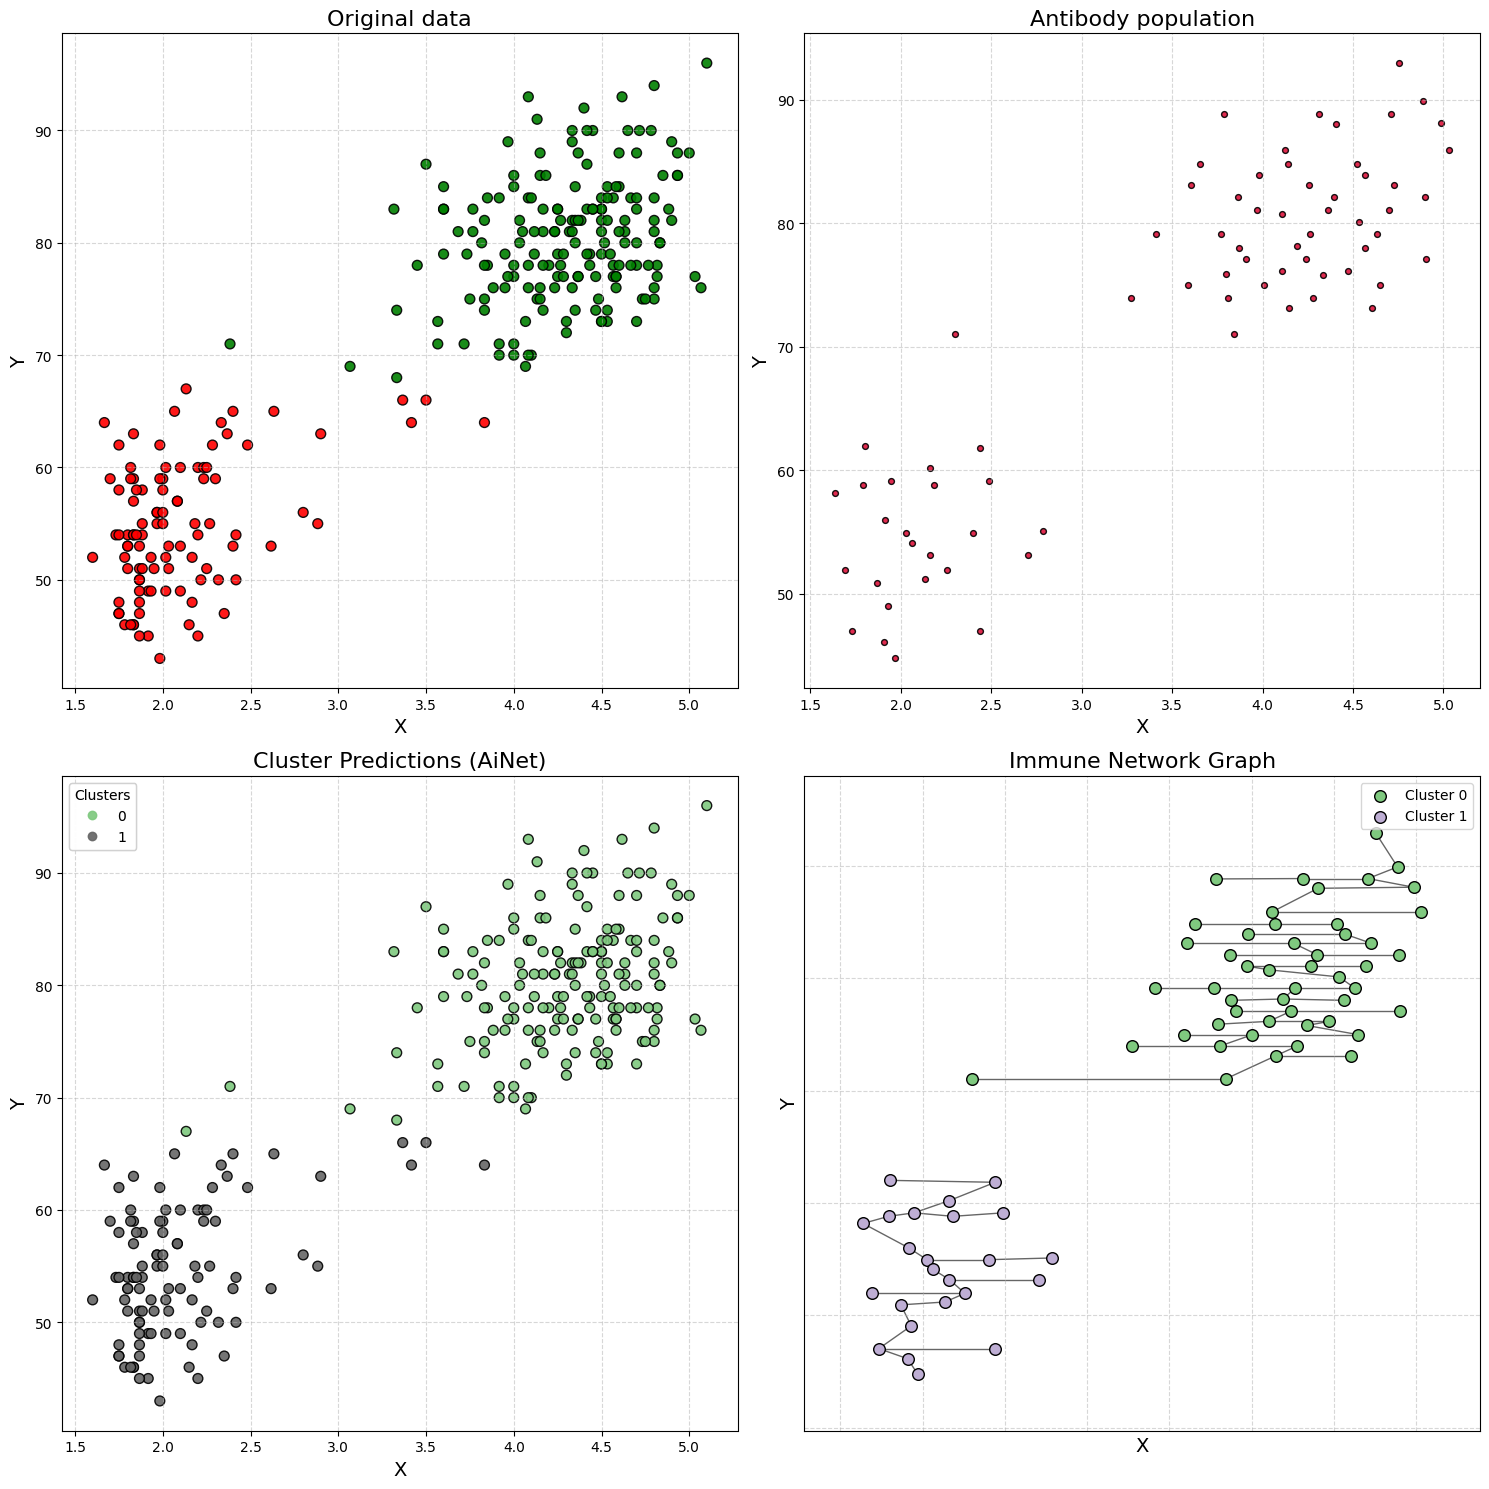

In [7]:
plot_immune_network(data, classes, predict_y, model, title_prefix="")

## 7. Training and visualizing AiNet on the data - Normalizing
The model will identify patterns, form clusters, and classify the samples.

In [8]:
# Normalizing data between 0 and 1
data = normalize_dados(data)

In [9]:
# Model Initialization
model = AiNet(suppression_threshold=0.95, affinity_threshold=0.97, mst_inconsistency_factor=2.5, seed=123)

predict_y = model.fit_predict(data)

✔ Memory antibodies successfully generated for labels (0, 1) | Number of clusters: 2 | Antibody population size: 43:  ┇██████████┇ 10/10 total training interactions


### 7.1 Evaluation of Clustering Quality using Silhouette Coefficient and Adjusted Rand Index

In [10]:
silhouette = silhouette_score(data, predict_y) # type: ignore
print(f"Silhouette Coefficient: {silhouette:.3f}")

ari = adjusted_rand_score(classes, predict_y) # type: ignore
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Coefficient: 0.755
Adjusted Rand Index (ARI): 0.913


#### 8. Training and Visualizing AiNet on Data

Displays four graphs: the original data, the antibody population, the clusters predicted by AiNet, and the graph of the formed immune network.

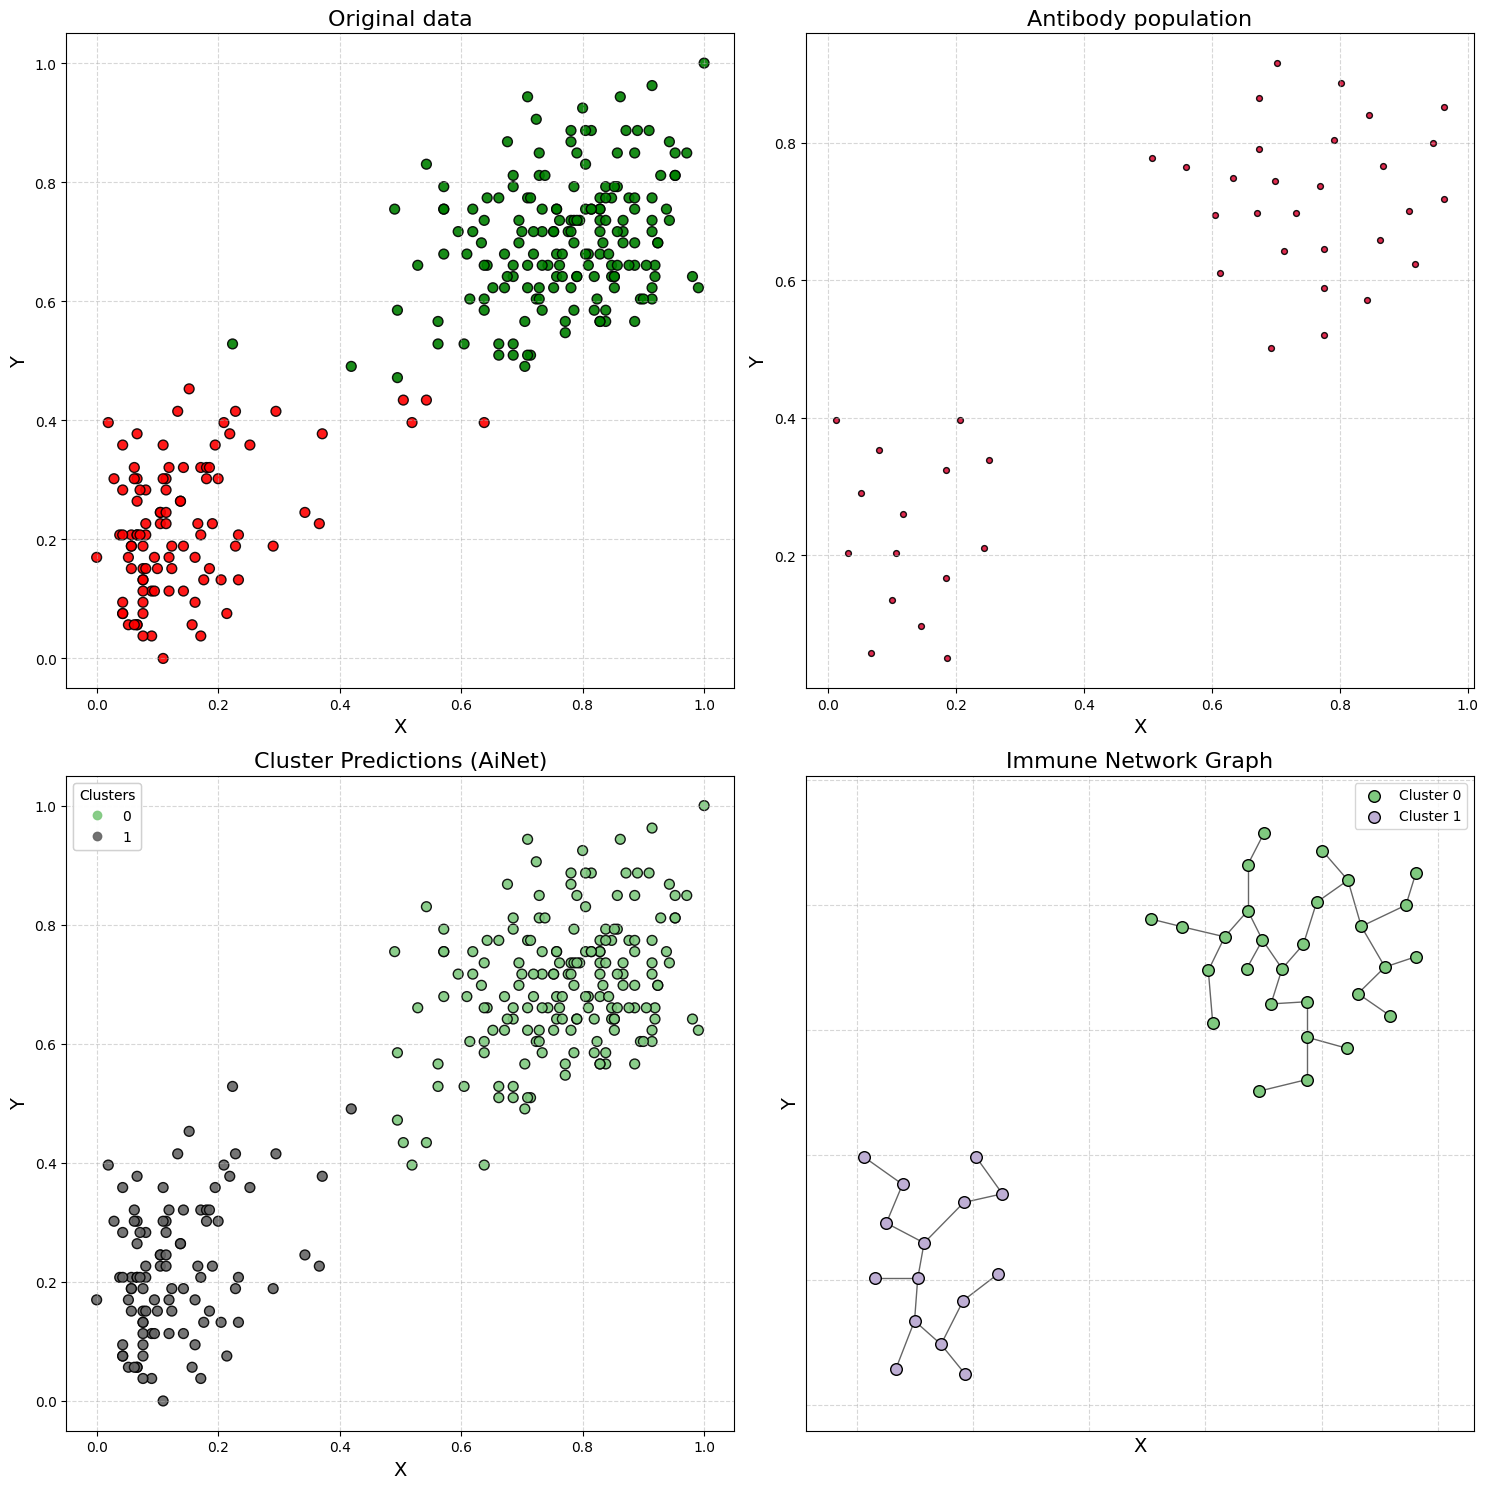

In [11]:
plot_immune_network(data, classes, predict_y, model, title_prefix="")